- 출처: https://github.com/yeomko22/ALS_implementation/blob/master/als.ipynb
- 안돌아가는 부분이 있어서 조금 수정한 버전 

# Set parameters 
- lambda_for_regularization : 목적함수 정규화항 파라미터 
- alpha : c(ui) 업데이트 파라미터 
- dimension : latent vector 사이즈 파라미터 

- 본 논문에서는 alpha = 40, dimension = 200 일 때 좋은 결과를 보인다고 명시되어 있음
- lambda는 Data-dependent, cross-validation에 의해 결정됨 

In [1]:
dimension = 200
alpha = 40
lambda_for_regularization = 40

## Rating matrix 예시 
- (10 x 11) matrix
- 10명의 유저, 11명의 아이템 

In [2]:
import numpy as np

# sample rating matrix
R_matrix = np.array([[0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0],
              [0, 3, 4, 0, 3, 0, 0, 2, 2, 0, 0],
              [0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5],
              [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 0, 3, 0, 0, 0, 0, 4, 5, 0]])


## M, N 값 , Latent Matrix 설정 
- n_users: M 값
- n_items: N 값 
- X: User의 Latent Matrix 
- Y: Item의 Latent Matrix 

In [3]:
n_users = R_matrix.shape[0]                     # M 값 
n_items = R_matrix.shape[1]                     # N 값 

# Latent matrix 
X = np.random.rand(n_users, dimension) * 0.01    # 0 ~ 0.01 사이 난수 
Y = np.random.rand(n_items, dimension) * 0.01

## P Matrix 만들기 
- 값이 있으면 1 
- 값이 없으면 0 

In [4]:
P_matrix = np.copy(R_matrix)
P_matrix[P_matrix > 0] = 1
P_matrix = np.nan_to_num(P_matrix, nan=0)

## C Matrix 만들기 
- C는 Confidence level을 의미 

In [5]:
C_matrix = 1 + alpha * R_matrix
# C_matrix = 1 + np.log(1+ np.nan_to_num(R_matrix) / 10**(-8))  -> log 스케일로 사용하는 방법 

## Loss function
- xTy: predict matrix  
- 제곱합(첫 번째 항) + 정규화(두 번째 항)으로 구성 

In [6]:
def loss_function(C_matrix, P_matrix, xTy, X, Y, lambda_for_regularization):
    # 첫 번째 항 
    predict_error = np.square(P_matrix - xTy)
    confidence_error = np.nansum(C_matrix * predict_error)

    # 두 번째 항 
    regularization =lambda_for_regularization * (np.nansum(np.square(X)) + np.nansum(np.square(Y)))
    total_loss = confidence_error + regularization
    
    return np.nansum(predict_error), confidence_error, regularization, total_loss

## Optimization 
- 시간복잡도 고려 


In [7]:
# X, Y 업데이트 
def optimize_user(X, Y, C_matrix, P_matrix, n_users, n_items, dimension,lambda_for_regularization):
    yT = np.transpose(Y)
    for u in range(n_users):
        Cu = np.diag(C_matrix[u])
        # yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y) -> 시간 복잡도 Trick 이전 
        yT_Cu_y = np.matmul(yT,Y) + np.matmul(np.matmul(yT, Cu - np.identity(n_items)), Y)          # 시간 복잡도 Trick 사용 
        lI = np.dot(lambda_for_regularization, np.identity(dimension))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P_matrix[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)                                              # Ax = b에서 x를 구하는 데 사용되는 함수 

def optimize_item(X, Y, C_matrix, P_matrix, n_users, n_items, dimension, lambda_for_regularization):
    xT = np.transpose(X)
    for i in range(n_users):
        Ci = np.diag(C_matrix[:, i])
        # xT_Ci_x = np.matmul(np.matmul(xT, Ci), X) -> 시간 복잡도 Trick 이전 
        xT_Ci_x = np.matmul(xT,X) + np.matmul(np.matmul(xT, Ci - np.identity(n_users)), X)          # 시간 복잡도 Trick 사용 
        lI = np.dot(lambda_for_regularization, np.identity(dimension))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P_matrix[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

In [8]:
# X, Y 업데이트 
def optimize_user_before_Trick(X, Y, C_matrix, P_matrix, n_users, n_items, dimension,lambda_for_regularization):
    yT = np.transpose(Y)
    for u in range(n_users):
        Cu = np.diag(C_matrix[u])
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)                                                   # 시간 복잡도 Trick 이전 
        # yT_Cu_y = np.matmul(yT,Y) + np.matmul(np.matmul(yT, Cu - np.identity(n_items)), Y)        # 시간 복잡도 Trick 사용 
        lI = np.dot(lambda_for_regularization, np.identity(dimension))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P_matrix[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)                                              # Ax = b에서 x를 구하는 데 사용되는 함수 

def optimize_item_before_Trick(X, Y, C_matrix, P_matrix, n_users, n_items, dimension, lambda_for_regularization):
    xT = np.transpose(X)
    for i in range(n_users):
        Ci = np.diag(C_matrix[:, i])
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)                                                     # 시간 복잡도 Trick 이전 
        # xT_Ci_x = np.matmul(xT,X) + np.matmul(np.matmul(xT, Ci - np.identity(n_users)), X)          # 시간 복잡도 Trick 사용 
        lI = np.dot(lambda_for_regularization, np.identity(dimension))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P_matrix[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

## Train
- 논문에는 보통 10번 정도 최적화한다고 명시되어 있음 

In [9]:
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(10):   
    if i!=0:   
        optimize_user(X, Y, C_matrix, P_matrix, n_users, n_items, dimension, lambda_for_regularization)
        optimize_item(X, Y, C_matrix, P_matrix, n_users,n_items, dimension, lambda_for_regularization)
    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C_matrix, P_matrix, predict, X, Y, lambda_for_regularization)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: %f" % confidence_error)
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)
    
predict = np.matmul(X, np.transpose(Y))
print('final predict')
print([predict])

----------------step 0----------------
predict error: 22.775467
confidence error: 3468.778687
regularization: 5.591364
total loss: 3474.370052
----------------step 1----------------
predict error: 27.878052
confidence error: 614.929717
regularization: 577.427170
total loss: 1192.356887
----------------step 2----------------
predict error: 31.750291
confidence error: 476.179407
regularization: 596.029950
total loss: 1072.209357
----------------step 3----------------
predict error: 30.853459
confidence error: 458.458783
regularization: 598.674272
total loss: 1057.133055
----------------step 4----------------
predict error: 29.348145
confidence error: 449.184925
regularization: 601.687732
total loss: 1050.872657
----------------step 5----------------
predict error: 27.902024
confidence error: 443.575746
regularization: 604.299881
total loss: 1047.875627
----------------step 6----------------
predict error: 26.682843
confidence error: 439.950515
regularization: 606.332847
total loss: 1046.

<Figure size 640x480 with 0 Axes>

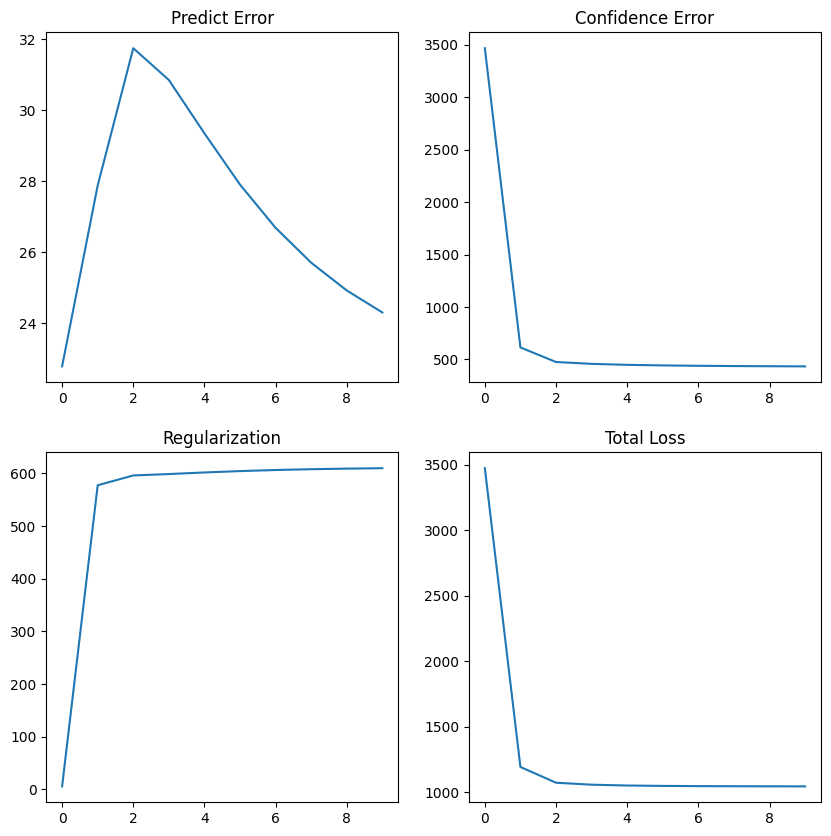

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()

In [11]:
pip freeze

anyio==3.7.1
appnope==0.1.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
attrs==23.2.0
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
certifi @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_477u68wvzm/croot/certifi_1671487773341/work/certifi
cffi==1.15.1
comm==0.1.4
cycler==0.11.0
debugpy==1.7.0
decorator==5.1.1
defusedxml==0.7.1
entrypoints==0.4
exceptiongroup==1.2.0
fastjsonschema==2.19.1
fonttools==4.38.0
gensim==4.2.0
idna==3.6
importlib-metadata==6.7.0
importlib-resources==5.12.0
ipykernel==6.16.2
ipython==7.34.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
jedi==0.19.1
Jinja2==3.1.2
jsonschema==4.17.3
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-server==1.24.0
jupyter_client==7.4.9
jupyter_core==4.12.0
jupyterlab-pygments==0.2.2
jupyterlab-widgets==3.0.9
kiwisolver==1.4.5
MarkupSafe==2.1.3
matplotlib==3.5.3
matplotlib-inline==0.1.6
mistune==3.0.2
nbclassic==1.0.0
nbclient==0.7.4
nbconvert==7.6.0
nbformat==5.8.0
nest-asyncio==1.5.8
networkx==2.6.3
not